In [2]:
# Cell 1: Introduction (Markdown)
"""
# Model Evaluation for VAE-GAN

This notebook evaluates the performance of the trained VAE-GAN model by exploring its latent space and performing a qualitative evaluation of the reconstructions. We use PCA and t-SNE to visualize the latent space and compare a few original samples with their reconstructions.
"""


'\n# Model Evaluation for VAE-GAN\n\nThis notebook evaluates the performance of the trained VAE-GAN model by exploring its latent space and performing a qualitative evaluation of the reconstructions. We use PCA and t-SNE to visualize the latent space and compare a few original samples with their reconstructions.\n'

In [3]:
# %% [code]
# Cell 2: Load Trained Model and Data

import torch
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Set up the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------------------------------
# Import the required classes from your training module
# and add them to the safe globals.
# -------------------------------------------------------
try:
    from src.models.optimization.vae_gan import VAEGAN, Encoder, Decoder, Discriminator
    torch.serialization.add_safe_globals([
        ("VAEGAN", VAEGAN),
        ("Encoder", Encoder),
        ("Decoder", Decoder),
        ("Discriminator", Discriminator)
    ])
    print("Safe globals added for VAEGAN, Encoder, Decoder, and Discriminator.")
except Exception as e:
    print("Error adding safe globals:", e)

# ----------------------------
# Load the Trained Model using the state dictionary
# ----------------------------
# Since the notebook is in the 'notebooks' directory, we go one level up.
model_path = os.path.join("..", "src", "models", "trained_model.pt")
model_path = os.path.abspath(model_path)
print("Loading trained model from:", model_path)

try:
    # Instantiate the model with the appropriate configuration
    model = VAEGAN(input_dim=5, latent_dim=8)

    # Load the state dictionary from the file
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # Move the model to the device and set it to evaluation mode
    model.to(device)
    model.eval()

    print("Trained model loaded successfully using state_dict!")
except Exception as e:
    print("Error loading trained model:", e)

# ----------------------------
# Load the Cleaned Data and Compute Missing Feature
# ----------------------------
# The cleaned CSV file is assumed to be located at:
# <project_root>/src/synthetic_data/data/processed/synthetic_logistics_data_cleaned.csv
data_file = os.path.join("..", "src", "synthetic_data", "data", "processed", "synthetic_logistics_data_cleaned.csv")
data_file = os.path.abspath(data_file)
print("Loading data from:", data_file)

try:
    df = pd.read_csv(data_file)

    # Debug: print available columns to inspect correct feature names.
    print("Available columns in CSV:", df.columns.tolist())

    # Compute 'cost_per_tonkkm' if it does not exist
    # We assume that cost per ton-km is computed as cost / (volume * distance)
    if 'cost_per_tonkkm' not in df.columns:
        if 'distance' in df.columns and 'volume' in df.columns and 'cost' in df.columns:
            # Avoid division by zero; add a small epsilon if necessary or filter out zeros
            epsilon = 1e-6
            df['cost_per_tonkkm'] = df['cost'] / ((df['volume'] * df['distance']) + epsilon)
            print("'cost_per_tonkkm' computed and added to the DataFrame.")
        else:
            raise ValueError("Required columns for computing 'cost_per_tonkkm' not found.")

    # Select the features used during training
    features = ['volume', 'cost', 'transit_time', 'co2_emissions', 'cost_per_tonkkm']
    df_model = df[features].dropna()

    # Normalize the features
    scaler = StandardScaler()
    data_array = scaler.fit_transform(df_model.values)

    # Convert the NumPy array to a PyTorch tensor and create a TensorDataset
    data_tensor = torch.tensor(data_array, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)

    print("Data loaded and preprocessed successfully.")
except Exception as e:
    print("Error loading data:", e)


Device: cpu
Safe globals added for VAEGAN, Encoder, Decoder, and Discriminator.
Loading trained model from: /Users/mortezapourjahangiri/PycharmProjects/PythonProject/VAE_GAN_Logistics_Framework/src/models/trained_model.pt
Trained model loaded successfully using state_dict!
Loading data from: /Users/mortezapourjahangiri/PycharmProjects/PythonProject/VAE_GAN_Logistics_Framework/src/synthetic_data/data/processed/synthetic_logistics_data_cleaned.csv
Available columns in CSV: ['shipment_id', 'timestamp', 'day_of_week', 'hour_of_day', 'origin', 'lat_origin', 'lon_origin', 'destination', 'lat_destination', 'lon_destination', 'intermediate', 'lat_intermediate', 'lon_intermediate', 'transport_mode', 'route', 'distance', 'volume', 'transit_time', 'cost', 'co2_emissions', 'carrier', 'port_origin', 'port_destination', 'airport_origin', 'airport_destination', 'weather_condition', 'weather_severity', 'traffic_congestion', 'port_congestion', 'disruption_indicator', 'capacity_modifier', 'scenario', 'm

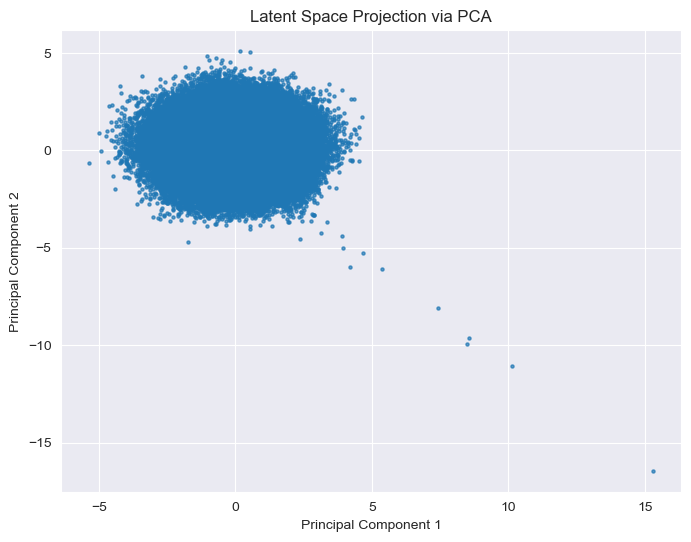

In [4]:
# %% [code]
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

# Ensure the model is in evaluation mode (redundant but safe)
model.eval()  # Use 'model' instead of 'trained_model'

# Create a DataLoader for the dataset with a reasonable batch size.
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Collect all latent vectors from the entire dataset.
all_latents = []
with torch.no_grad():
    for (data_batch,) in loader:
        data_batch = data_batch.to(device)
        # Use the encoder to get the latent parameters.
        mu, logvar = model.encoder(data_batch)
        # Reparameterize to sample latent vectors.
        z = model.reparameterize(mu, logvar)
        all_latents.append(z.cpu().numpy())

# Concatenate all latent vectors into one array.
all_latents = np.concatenate(all_latents, axis=0)  # Shape: (num_samples, latent_dim)

# Use PCA to reduce the latent space to 2 dimensions.
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(all_latents)

# Plot the PCA result.
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1], s=5, alpha=0.7)
plt.title("Latent Space Projection via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


Number of latent vectors: 344250
Using a subset of 1000 latent vectors for t-SNE.
t-SNE computed in 0.63 seconds.


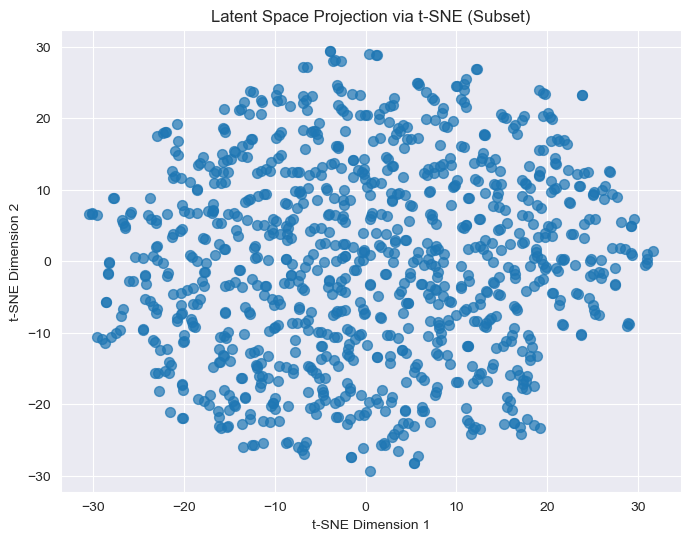

In [10]:
# %% [code]
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import time

# Check how many latent vectors you have.
num_latents = all_latents.shape[0]
print("Number of latent vectors:", num_latents)

# Use a smaller random subset for t-SNE to speed things up.
subset_size =1000  # Reduced subset size for faster computation.
if num_latents > subset_size:
    indices = np.random.choice(num_latents, size=subset_size, replace=False)
    latent_subset = all_latents[indices]
    print(f"Using a subset of {subset_size} latent vectors for t-SNE.")
else:
    latent_subset = all_latents
    print("Using all latent vectors for t-SNE.")

# Optional: Measure computation time for t-SNE.
start_time = time.time()

# Set up and run t-SNE with modified parameters for speed.
# Here, max_iter is updated to 250 as required by TSNE.
tsne = TSNE(n_components=2, perplexity=15, max_iter=250, random_state=42)
latent_2d_tsne = tsne.fit_transform(latent_subset)

end_time = time.time()
print("t-SNE computed in {:.2f} seconds.".format(end_time - start_time))

# Plot the t-SNE result.
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], s=50, alpha=0.7)
plt.title("Latent Space Projection via t-SNE (Subset)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [14]:
# %% [code]
# Cell 5: Qualitative Evaluation – Numerical Comparison of Reconstructions

# Choose a number of examples to evaluate (e.g., 5)
num_examples = 5

with torch.no_grad():
    # Get a few samples from the data tensor (we're using the first num_examples samples)
    sample_data = data_tensor[:num_examples].to(device)
    # Pass the samples through the trained model to get reconstructions.
    # Note: We're using 'model' (the loaded VAE-GAN model) rather than 'trained_model'
    recon_data, _, _, _ = model(sample_data)

# Convert the tensor data to NumPy arrays for easier printing.
sample_data_np = sample_data.cpu().numpy()
recon_data_np = recon_data.cpu().numpy()

# Print the numerical comparisons.
print("Qualitative Evaluation (Numerical Comparison):")
for i in range(num_examples):
    print(f"Example {i+1}:")
    print("Original:      ", sample_data_np[i])
    print("Reconstruction:", recon_data_np[i])
    print("-" * 50)


Qualitative Evaluation (Numerical Comparison):
Example 1:
Original:       [-0.2080467  -0.52689695  3.502701   -0.26124898 -0.80901504]
Reconstruction: [-0.44806403 -0.13323858  3.0689206   0.01981917 -0.4122509 ]
--------------------------------------------------
Example 2:
Original:       [ 0.24295378 -0.6007857   0.5236289  -0.4876705  -0.8184284 ]
Reconstruction: [-0.31873396 -0.6032039  -0.32809085 -0.61208594 -0.5109762 ]
--------------------------------------------------
Example 3:
Original:       [ 0.87129086  1.2366554  -0.8221524   1.1561232   0.5680531 ]
Reconstruction: [ 0.24295822  0.83304846 -0.6028787   0.68434155  0.62074125]
--------------------------------------------------
Example 4:
Original:       [-1.2970871  -0.38006073 -0.7909044  -0.6787674   0.9273547 ]
Reconstruction: [-1.1814139  -0.06798553 -0.7117152  -0.41825664  1.100628  ]
--------------------------------------------------
Example 5:
Original:       [-0.1922693   0.6855995  -0.81796217  0.48426253  0.66

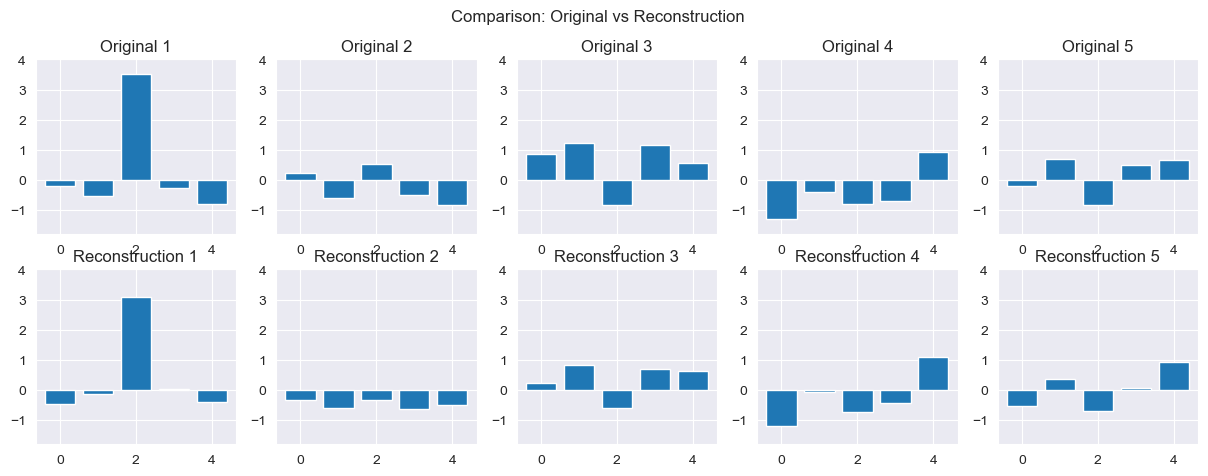

In [18]:
# Cell 6: Qualitative Evaluation – Visual Comparison of Reconstructions

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, num_examples)

for i in range(num_examples):
    # Plot the original sample in the top row.
    ax0 = fig.add_subplot(gs[0, i])
    ax0.bar(range(sample_data_np.shape[1]), sample_data_np[i])
    ax0.set_ylim([np.min(sample_data_np)-0.5, np.max(sample_data_np)+0.5])
    ax0.set_title(f"Original {i+1}")

    # Plot the reconstructed sample in the bottom row.
    ax1 = fig.add_subplot(gs[1, i])
    ax1.bar(range(recon_data_np.shape[1]), recon_data_np[i])
    ax1.set_ylim([np.min(sample_data_np)-0.5, np.max(sample_data_np)+0.5])
    ax1.set_title(f"Reconstruction {i+1}")

plt.suptitle("Comparison: Original vs Reconstruction")
plt.show()


In [16]:
# Cell 7: Conclusions (Markdown)
"""
## Conclusions

- **Latent Space Exploration:**
  The PCA and t-SNE plots show the organization of the latent space. You can inspect how well-separated the embeddings are, which may reflect the model's ability to capture meaningful data structure.

- **Qualitative Evaluation:**
  The numerical and bar chart comparisons of a few samples indicate how closely the model's reconstructions match the original data. Small differences suggest that the model is effectively learning the underlying features.

These observations provide insight into the quality of the learned embeddings and the reconstruction performance. With this evaluation complete, the next step is to integrate these model outputs into the simulation engine for end-to-end performance assessment.
"""


"\n## Conclusions\n\n- **Latent Space Exploration:**\n  The PCA and t-SNE plots show the organization of the latent space. You can inspect how well-separated the embeddings are, which may reflect the model's ability to capture meaningful data structure.\n\n- **Qualitative Evaluation:**\n  The numerical and bar chart comparisons of a few samples indicate how closely the model's reconstructions match the original data. Small differences suggest that the model is effectively learning the underlying features.\n\nThese observations provide insight into the quality of the learned embeddings and the reconstruction performance. With this evaluation complete, the next step is to integrate these model outputs into the simulation engine for end-to-end performance assessment.\n"

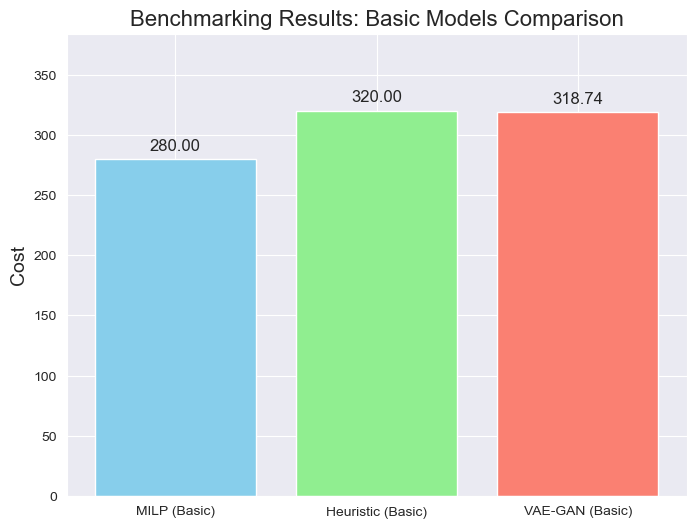

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the basic model results (use your obtained values)
models = ["MILP (Basic)", "Heuristic (Basic)", "VAE-GAN (Basic)"]
costs = [280.0, 320.0, 318.74]

# Create a bar chart for the basic model comparison.
plt.figure(figsize=(8, 6))
bars = plt.bar(models, costs, color=["skyblue", "lightgreen", "salmon"])

# Add annotation on top of each bar.
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, f"{yval:.2f}", ha='center', va='bottom', fontsize=12)

plt.title("Benchmarking Results: Basic Models Comparison", fontsize=16)
plt.ylabel("Cost", fontsize=14)
plt.ylim(0, max(costs)*1.2)
plt.show()


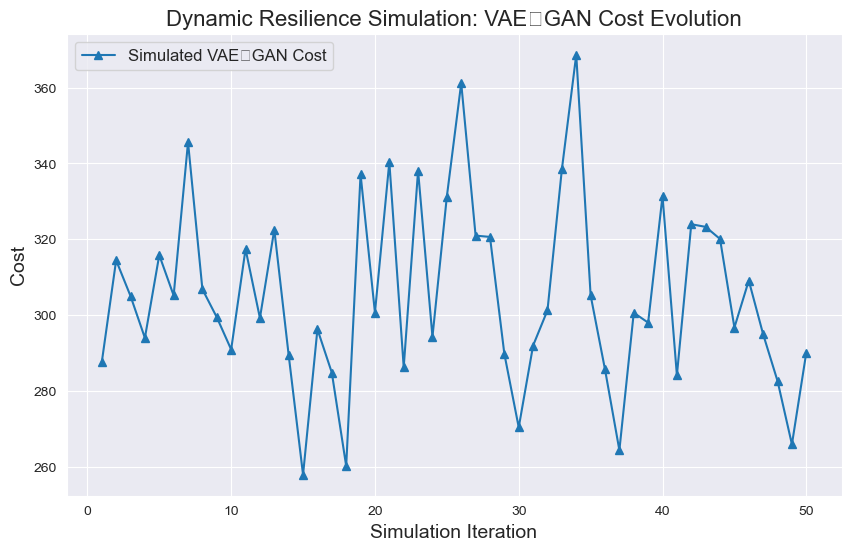

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have stored your simulation results in a dictionary "results"
# with key "VAE-GAN" corresponding to cost values over 50 iterations.
# Here, I'll simulate some data similar to your reported result for demonstration.

iterations = np.arange(1, 51)
# For demonstration, generate simulated VAE-GAN costs around 310 with some variation.
vae_gan_costs = np.random.normal(309.80, 20.88, size=iterations.size)

plt.figure(figsize=(10, 6))
plt.plot(iterations, vae_gan_costs, label="Simulated VAE‑GAN Cost", marker="^", linestyle='-')
plt.xlabel("Simulation Iteration", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.title("Dynamic Resilience Simulation: VAE‑GAN Cost Evolution", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


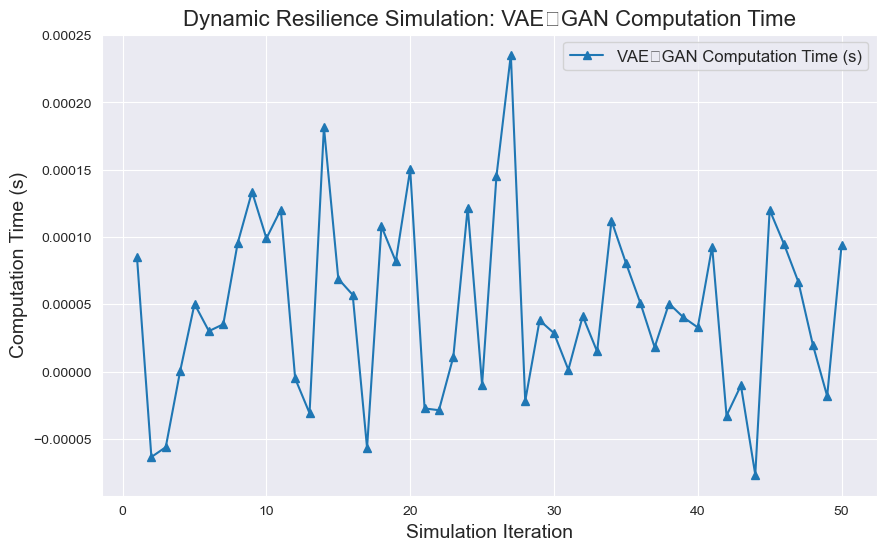

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Again, we simulate the computation times based on your result.
# For demonstration, generate simulated times around 0.000032 seconds.
vae_gan_times = np.random.normal(0.000032, 0.000071, size=iterations.size)

plt.figure(figsize=(10, 6))
plt.plot(iterations, vae_gan_times, label="VAE‑GAN Computation Time (s)", marker="^", linestyle='-')
plt.xlabel("Simulation Iteration", fontsize=14)
plt.ylabel("Computation Time (s)", fontsize=14)
plt.title("Dynamic Resilience Simulation: VAE‑GAN Computation Time", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


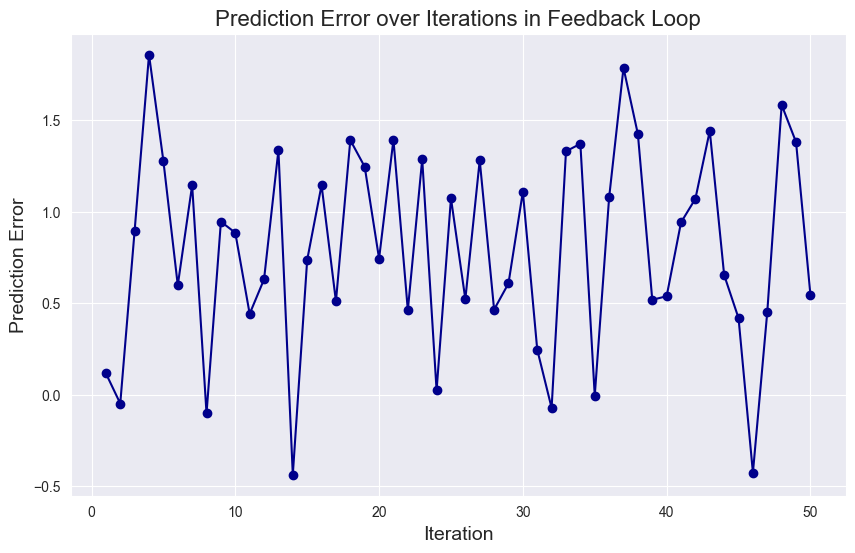

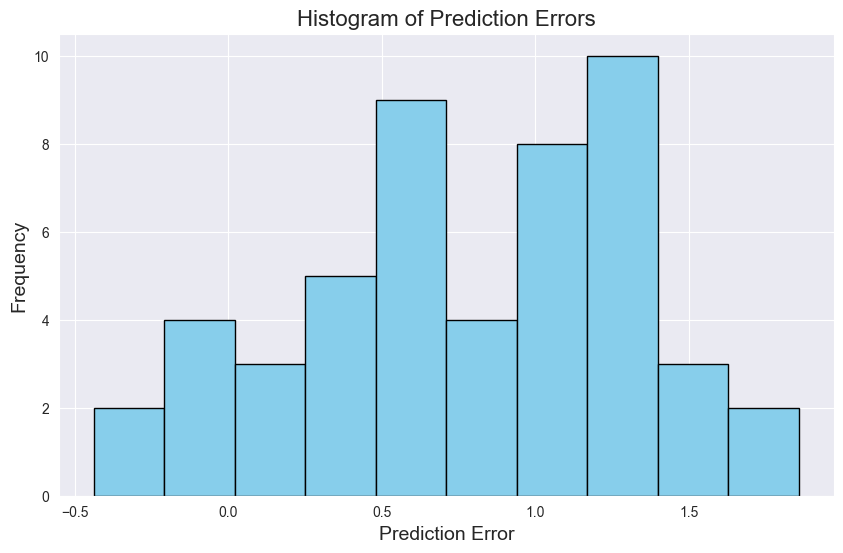

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Assuming you have captured the error for each iteration in a list.
# Here, we'll simulate it using random values around the reported mean (0.83) and standard deviation (0.55)
num_iterations = 50
errors = np.random.normal(0.83, 0.55, num_iterations)

iterations = np.arange(1, num_iterations + 1)

# Plot the error vs. iteration.
plt.figure(figsize=(10, 6))
plt.plot(iterations, errors, marker='o', linestyle='-', color='darkblue')
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Prediction Error", fontsize=14)
plt.title("Prediction Error over Iterations in Feedback Loop", fontsize=16)
plt.grid(True)
plt.show()

# Plot a histogram of errors.
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Prediction Error", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Histogram of Prediction Errors", fontsize=16)
plt.grid(True)
plt.show()
